In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import gc
gc.collect()

0

# Training Data
### Quick Summary
- Training data stored in train.csv
- Training data has only 1 feature - a time series "acoustic_data"
- Each time/step of "acoustic_data" has a corresponding output/target - "time_to_failure"
- In the otherwords, Input data is the time series "acoustic_data", and Output/Target data is the time series "time_to_failure"
- Reading training data to a Pandas dataframe is very memory consuming. The memory can be drastically reduced if we define datatype before reading the csv to dataframe 

In [2]:
%%time
# read the train.csv to pandas data frame
trainDF = pd.read_csv('train.csv')

Wall time: 3min 1s


In [3]:
%%time
# display the training data summary
trainDF_summary = trainDF.describe()

Wall time: 3min 53s


In [4]:
# let's have a quick look at the dataframe object
print("The dimension of the training dataframe: ", trainDF.shape)
print("Columns of the training data frame: ", trainDF.columns)

# Now we know for the training data it is a 629 million by 2 matrix
# Two columns/features are "accoustic_data" and "time_to_failure", seperately

The dimension of the training dataframe:  (629145480, 2)
Columns of the training data frame:  Index(['acoustic_data', 'time_to_failure'], dtype='object')


In [5]:
# Now let's check the data type of these two columns and the size of the dataframe
print(trainDF.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
acoustic_data      int64
time_to_failure    float64
dtypes: float64(1), int64(1)
memory usage: 9.4 GB
None


In [6]:
# Also, let's check the summary of the dataframe
print("Quick summary of the dataframe: ")
print(trainDF_summary)

Quick summary of the dataframe: 
       acoustic_data  time_to_failure
count   6.291455e+08     6.291455e+08
mean    4.519468e+00     5.678292e+00
std     1.073571e+01     3.672697e+00
min    -5.515000e+03     9.550396e-05
25%     2.000000e+00     2.625997e+00
50%     5.000000e+00     5.349798e+00
75%     7.000000e+00     8.173396e+00
max     5.444000e+03     1.610740e+01


### Reduce Memory Usage

In [7]:
# Here we know that "acoustic_data" is between -5515 and 5444, and "time_to_failure" is between 0.0 and 16.1074
# "acoustic_data" is int64 and "time_to_failure" is float64
# Refer to https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html
# We can absolutely set "acoustic_data" to int16 and "time_to_failure" to float32
trainDF['acoustic_data'] = trainDF['acoustic_data'].astype('int16')
trainDF['time_to_failure'] = trainDF['time_to_failure'].astype('float32')
# let's see if memory use is reduced
print(trainDF.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float32
dtypes: float32(1), int16(1)
memory usage: 3.5 GB
None


In [8]:
# check again the dataframe summary to make sure everything stays the same
trainDF_summary = trainDF.describe()
print(trainDF_summary)
del trainDF_summary
gc.collect()

       acoustic_data  time_to_failure
count   6.291455e+08     6.291455e+08
mean    4.519468e+00     4.477084e-01
std     1.073571e+01     2.612789e+00
min    -5.515000e+03     9.550396e-05
25%     2.000000e+00     2.625997e+00
50%     5.000000e+00     5.349798e+00
75%     7.000000e+00     8.173395e+00
max     5.444000e+03     1.610740e+01


35

### Plot 1% of the Training Data    

In [9]:
# borrowed the plotting function from 
# https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction

def plot_act_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    ax1.set_ylim(-5000,5000)
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    ax2.set_ylim(0,15)
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

10

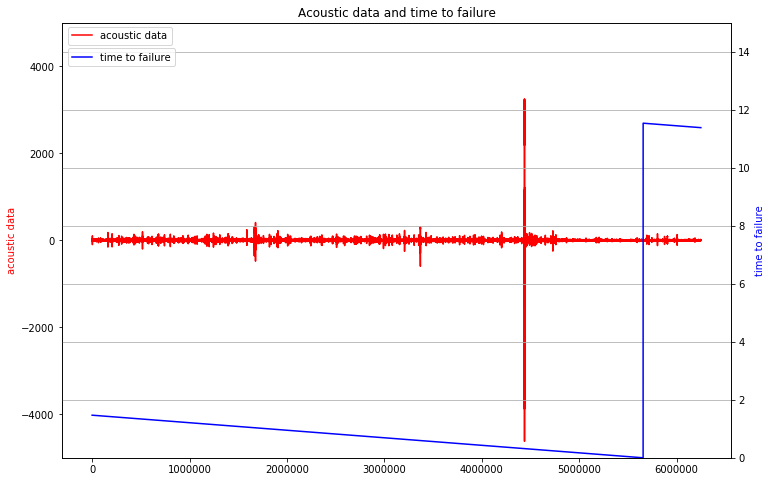

In [10]:
# recall the training data has 629145480 rows of entries. plotting 1% = 6291455 entries
# let's plot the first 1% of the training data
t = 6249455
train_act_1pc = trainDF['acoustic_data'].values[:t]
train_ttf_1pc = trainDF['time_to_failure'].values[:t]

plot_act_ttf_data(train_act_1pc, train_ttf_1pc)

# release memory
del train_act_1pc
del train_ttf_1pc
gc.collect()

4259

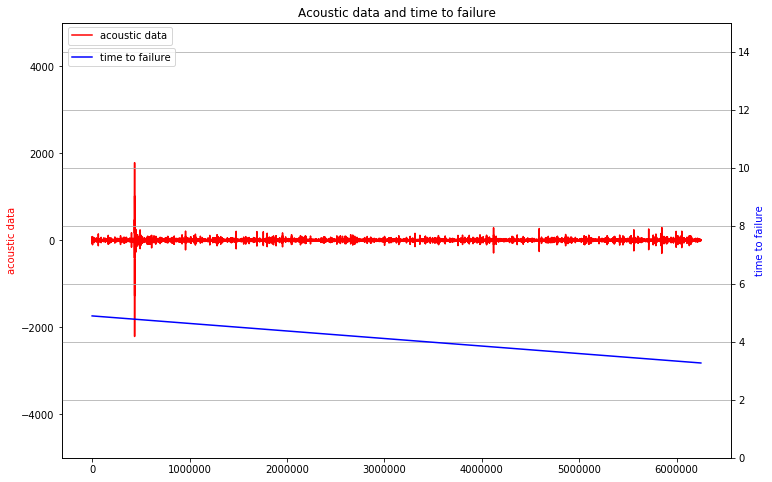

In [11]:
# let's take a look of another 1% of data
train_act_1pc = trainDF['acoustic_data'].values[5*t:6*t]
train_ttf_1pc = trainDF['time_to_failure'].values[5*t:6*t]

plot_act_ttf_data(train_act_1pc, train_ttf_1pc)

# release memory
del train_act_1pc
del train_ttf_1pc
gc.collect()

4261

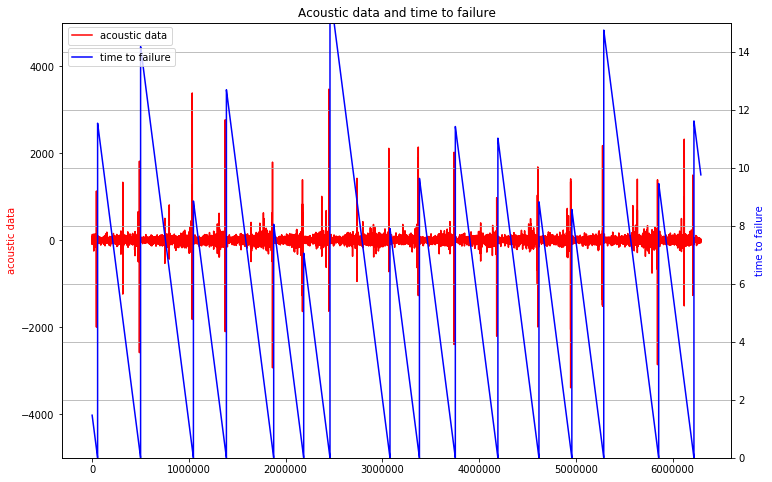

In [12]:
# another way to plot 1% of the training data is to sample the data at every 100 data points
# this actually gives a more interesting plot
train_act_1pc = trainDF['acoustic_data'].values[::100]
train_ttf_1pc = trainDF['time_to_failure'].values[::100]
plot_act_ttf_data(train_act_1pc, train_ttf_1pc)

# release memory
del train_act_1pc
del train_ttf_1pc
gc.collect()

In [13]:
# release memory
del trainDF
gc.collect()

4266

# Test Data
### Summary
- Each test file has 150000 records/datapoints of acoustic_data
- Goal: forecast time to failure based on each set of test data, see submission format

In [14]:
%%time
# Let's just take a look at one test data in the test folder
# read the seg_00030f.csv to pandas data frame
testDF = pd.read_csv('test\seg_00030f.csv')

Wall time: 28.7 ms


In [15]:
# Let's check the test data summary
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 1 columns):
acoustic_data    150000 non-null int64
dtypes: int64(1)
memory usage: 1.1 MB


In [16]:
testDF_summary = testDF.describe()
print(testDF_summary)

       acoustic_data
count   150000.00000
mean         4.49178
std          4.89369
min        -75.00000
25%          2.00000
50%          4.00000
75%          7.00000
max        115.00000


Looks like each test data contain a chunk of 150000 acoustic_data data points, let's verify it

In [17]:
test_filenames = glob.glob("test\*.csv")

datapoint = []
for f in tqdm(test_filenames):
    tempDF = pd.read_csv(f)
    dpoints = tempDF.shape[0]
    if dpoints not in datapoint:
        datapoint.append(dpoints)
    del tempDF    

print(set(datapoint))
gc.collect()


{150000}


0

Now we know every test file has 150000 records;  The goal is to forecast the time_to_failure values given each of these 150000 records

In [18]:
# create a function to plot the test data
def plot_act_data(test_ad_sample_df, title="Acoustic data"):
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.plot(test_ad_sample_df, color='r')
    plt.ylim(-2000, 2000)
    plt.ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    plt.grid(True)

17

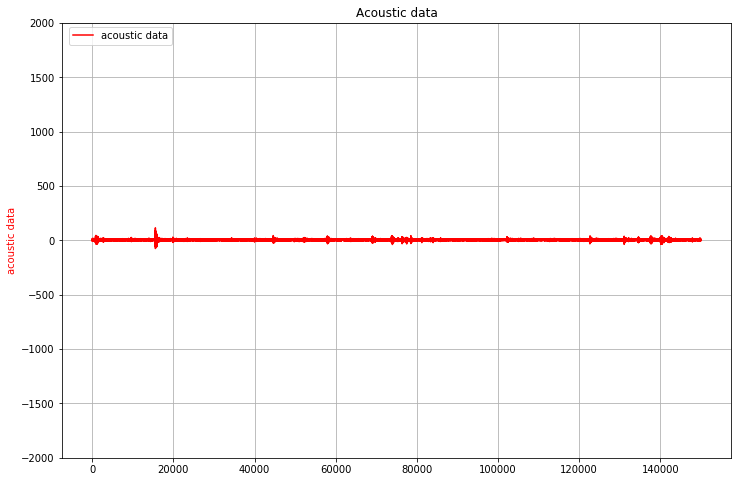

In [19]:
# let's plot one of the test file
plot_act_data(testDF)
del testDF
gc.collect()